In [137]:
import requests
import pandas as pd
from pandas import read_html
import matplotlib.pyplot as plt
import os.path
import numpy as np
import scipy.stats as stats
import matplotlib.dates as mdates
import math


In [54]:
def get_odstavky(df,od,do):
    indexes = df['Event Start']
    df.index= indexes
    dat = df

    dat.index = dat.index.astype('string').str.split('+',expand=True).droplevel(1)
    dat.index = pd.to_datetime(dat.index)

    dat['Event Start'] = dat['Event Start'].astype('string').str.split('+',expand=True).iloc[:,0]
    dat['Event Start'] = pd.to_datetime(dat['Event Start'])
    dat['Event Start'] = dat['Event Start'].round('H')
    dat['Event Stop'] = dat['Event Stop'].astype('string').str.split('+',expand=True).iloc[:,0]
    dat['Event Stop'] = pd.to_datetime(dat['Event Stop'])
    dat['Event Stop'] = dat['Event Stop'].round('H')

    dat['Odstavka'] = dat['Technical Capacity'] - dat['Available Capacity']

    lst = pd.date_range(start=od, end=do, freq='1D')

    # create new DataFrame
    df2 = pd.DataFrame(0, index=lst, columns=dat['Affected Asset or Unit'].unique())

    # loop over assets and dates and aggregate data for each day
    for col in df2.columns:
        for date in df2.index:
            mask = (dat['Event Start'] <= date) & (dat['Event Stop'] >= date) & (dat['Affected Asset or Unit'] == col)
            df2.loc[date, col] = dat.loc[mask]['Odstavka'].sum()

    # aggregate data for each day and add retrieved date
    df2['Odstavka'] = df2.sum(axis=1)
    df2 = df2[['Odstavka']]
    df2.index.name = 'Date'
    df2['Retrieved'] = pd.Timestamp.now().floor('D').strftime("%Y-%m-%d")
    return df2

In [109]:
def normal_line(data):
    mean = data['Odstavka'].mean()
    std_dev = np.std(data['Odstavka'])
    x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
    y = 1/(std_dev * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std_dev**2) )
    return x,y


In [55]:
s=requests.session()
s1=s.get("https://umm.gassco.no")
s2=s.get("https://umm.gassco.no/disclaimer/acceptDisclaimer?")
data = read_html(s2.text, attrs={"class": "msgTable"})
df = pd.DataFrame(data[0])
exit_terminals = pd.DataFrame(data[1])
start = "2023-01-01"
end = "2024-01-01"

In [44]:
# set file path and name
file_path = 'odstavky91.xlsx'

# check if file exists
if os.path.isfile(file_path):
    # read existing file
    existing_data = pd.read_excel(file_path)
    existing_data.set_index('Date', inplace=True)
    
    # check if last retrieved date is today
    last_date = pd.to_datetime(existing_data['Retrieved'].iloc[-1])
    today = pd.Timestamp.now().floor('D')
    
    if last_date == today:
        # do nothing
        pass
    else:
        # download new data
        new_data = get_odstavky(df, start, end)
        
        # append new data to existing file
        updated_data = existing_data.append(new_data)
        updated_data.to_excel(file_path)
else:
    # download new data and create new file
    new_data = get_odstavky(df, start, end)
    new_data.to_excel(file_path)


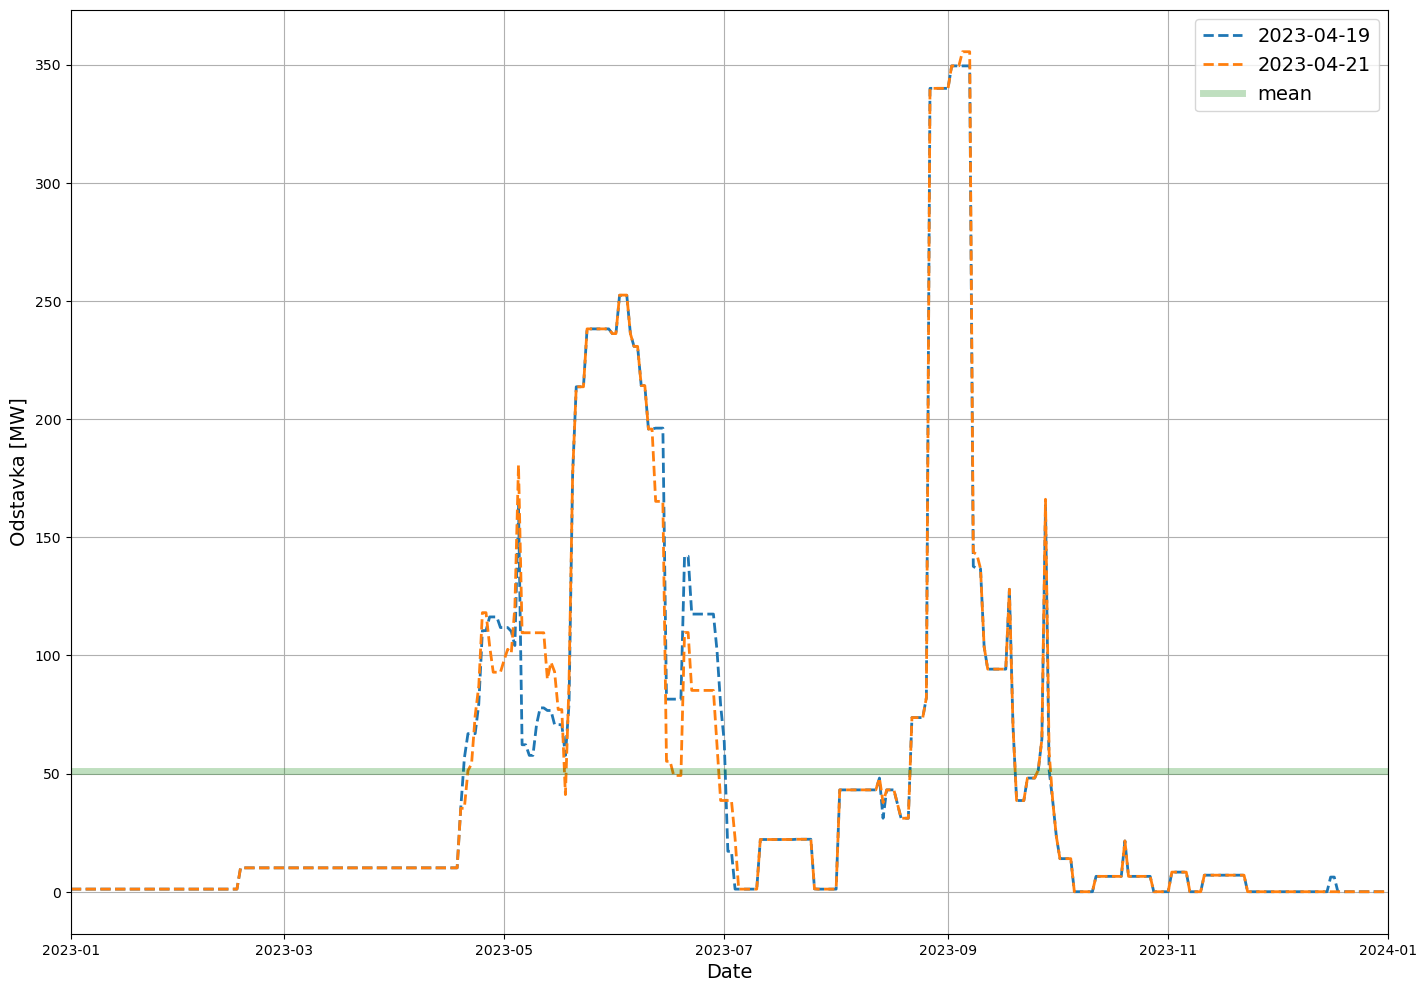

In [132]:
# group by Retrieved column
grouped = data.groupby(data['Retrieved'])

# create a new figure
fig, ax = plt.subplots(figsize=(17, 12))

# iterate over groups and plot a line for each group
for group_name, group_data in grouped:
    ax.plot(group_data.index, group_data['Odstavka'], label=group_name,linestyle = '--',linewidth=2)

# set labels, legend, and grid
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Odstavka [MW]', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
mean = data['Odstavka'].mean()
ax.axhline(y=mean, color='g', linestyle='-', label='mean',linewidth=5, alpha=0.25)
# std_dev = stats.stdev(data['Odstavka'])
# ax.axhline(y=std_dev, color='b', linestyle='-', label='std_dev',linewidth=5, alpha=0.25)
''' plot mean as logarithmic line '''


ax.set_xlim([pd.Timestamp('2023-01-01'), pd.Timestamp('2024-01-01')])
ax.legend(fontsize=14)
ax.grid(True)





In [134]:
mean = np.mean(data['Odstavka'])
std_dev = np.std(data['Odstavka'])

x = np.linspace(mean - 3*std_dev, mean + 3*std_dev,group_data['Odstavka'].count() )

y = stats.norm.pdf(x, mean, std_dev)


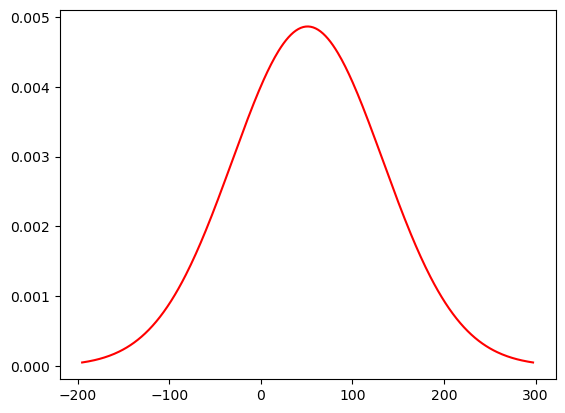

In [135]:
plt.plot(x, y, 'r')